# Downloads and Imports

In [18]:
%%capture
import nltk
import pandas as pd
import urllib.request
import json
from difflib import ndiff
from collections import Counter
from nltk.corpus import wordnet as wn
import pandas as pd
import os
pd.options.mode.chained_assignment = None
nltk.download('wordnet')

In [2]:
import sys
sys.path.append('../')

from utils.tools import DistanceTools
from utils.setup import SetupFunctions
from utils.evaluation import Evaluation

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
setup = SetupFunctions()
evals = Evaluation()

In [4]:
def createData(link, filename = "../data//data.dat"):

  """
  This function downloads the data from the link and saves it locally. The files that can be parsed have the structure 
  $correct_word
  incorrect_word
  incorrect_word 
  .
  .
  .
  It scans for duplicate correct words and prints them too
  It returns a dataframe with the columns 'words' and 'mispellings' and a list of repeats(for the stats)  
  
  """
  urllib.request.urlretrieve(link, filename)
  current_key = None
  result_dict = {}
  repeats = []
  print('About the spellcheck dataset:\n')
  for line in open(filename).readlines():

      lines = line.strip().split('\n')

      if lines[0].startswith('$'):
              current_key = lines[0][1:].lower()
              if(current_key not in result_dict.keys()):
                  result_dict[current_key] = []
              else:
                print('The word "' + current_key + '" occurs more than once')
                repeats.append(current_key)
                #result_dict[current_key].append(lines[0].lower())
              #print(line[1:-2])
              #result_dict[current_key] = []
      else:
              result_dict[current_key].append(lines[0].lower())

  df = pd.DataFrame([result_dict.keys(), result_dict.values()]).T
  df.columns = ['words', 'misspellings']

  return df, repeats

# For parallel processing

In [5]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers = 300)

INFO: Pandarallel will run on 300 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [15]:
def findingClosestWords(start_index = 0, end_index = 10, df =None, 
                        k_vals = [1,5,10], 
                        link =  "https://www.dcs.bbk.ac.uk/~roger/missp.dat"):

  tools = DistanceTools()
  repeats = []
  if (df is None):
    df, repeats = createData(link = link)  #can mention filename and link here

  df, starters = setup.findPossibleFirstLetters(df)
  dictionary, word_count = setup.buildDictionary()
  setup.describeData(df, repeats, word_count)
  df1 = df[start_index : end_index]
  df1['k_list'] = df1.parallel_apply(lambda x: tools.find_k(x.words, x.misspellings, dictionary, starters), axis = 1)
  results = evals.getResults(df1)
  print('\n')
  success_at_k = evals.getAverageSuccessValues(results, df1.num_of_words.sum(), k_vals)
  df1.drop(columns = ['num_of_words'], inplace = True)
  df1.to_json('spellCheck.json')
  with open("evalResults.json", "w") as fp:
    json.dump(success_at_k, fp)
  print('-----------------------------------------------------------------------------------------------------')
  return df1

In [39]:
links = { 'birkbeck' : 'https://www.dcs.bbk.ac.uk/~roger/missp.dat',
        'aspell' : 'https://www.dcs.bbk.ac.uk/~roger/aspell.dat',
        'wikipedia' : 'https://www.dcs.bbk.ac.uk/~roger/wikipedia.dat' }

k_values = findingClosestWords(start_index = 1, end_index = 5, k_vals = [1,5,10], link = links['birkbeck'])

About the spellcheck dataset:

The word "cambridge" occurs more than once
The word "february" occurs more than once
The word "miss" occurs more than once
The word "monday" occurs more than once
The word "sunday" occurs more than once
The word "wednesday" occurs more than once

There are a total of 6130 unique correct words and 6 repeats which totals to 6136 words
There are a total of 36133 misspelt words in the dataset

About the wordnet dictionary:

There are 147306 words in the wordnet dictionary

k = 1 in 5 search(es)


Success at 1 is 100.0 %
Success at 5 is 100.0 %
Success at 10 is 100.0 %
-----------------------------------------------------------------------------------------------------


# Concatenate result files

In [75]:
def concatenateParallelRuns(k_vals = [1, 5, 10], link = links['birkbeck']):
  
  df, repeats = createData(link = link)  #can mention filename and link here
  df, starters = setup.findPossibleFirstLetters(df)
  num_of_words = df.num_of_words.sum()
  dictionary, word_count = setup.buildDictionary()
  setup.describeData(df, repeats, word_count)

  df = pd.DataFrame()
  for json_file in os.listdir('../results//birkbeckResults//parts'):
      file_name = '../results//birkbeckResults//parts//' + json_file
      df1 = pd.read_json(file_name)
      df = pd.concat([df, df1])
      
  results = evals.getResults(df)
  print('\n')
  success_at_k = evals.getAverageSuccessValues(results, num_of_words, k_vals)
  df.to_json('../results//birkbeckResults//full//spellCheck.json')
  with open("../results//birkbeckResults//full//evalResults.json", "w") as fp:
    json.dump(success_at_k, fp)
  print('-----------------------------------------------------------------------------------------------------')
  return df,results, starters

In [76]:
df, results, starters = concatenateParallelRuns()

About the spellcheck dataset:

The word "cambridge" occurs more than once
The word "february" occurs more than once
The word "miss" occurs more than once
The word "monday" occurs more than once
The word "sunday" occurs more than once
The word "wednesday" occurs more than once

There are a total of 6130 unique correct words and 6 repeats which totals to 6136 words
There are a total of 36133 misspelt words in the dataset

About the wordnet dictionary:

There are 147306 words in the wordnet dictionary

k = 4 in 2501 search(es)
k = 1 in 19162 search(es)
k = 2 in 7151 search(es)
k = 5 in 1376 search(es)
k = 3 in 4184 search(es)
k = 7 in 418 search(es)
k = 6 in 756 search(es)
k = 10 in 78 search(es)
k = 8 in 245 search(es)
k = 9 in 149 search(es)
k = 11 in 48 search(es)
k = 12 in 33 search(es)
k = 13 in 19 search(es)
k = 16 in 4 search(es)
k = 15 in 1 search(es)
k = 14 in 7 search(es)
k = 17 in 1 search(es)


Success at 1 is 53.03 %
Success at 5 is 95.13 %
Success at 10 is 99.69 %
----------

Text(0.5, 1.0, 'Most mistaken starting letters')

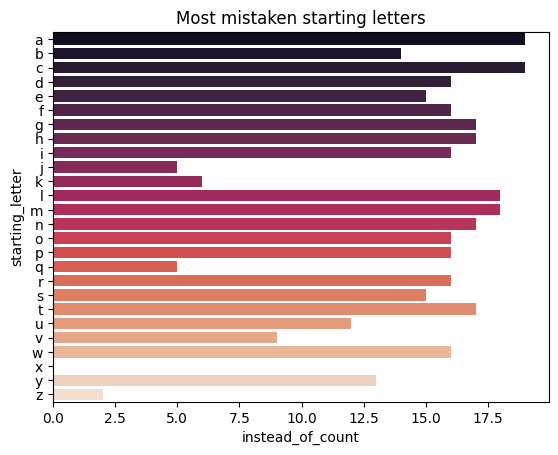

In [132]:
fig = sns.barplot(startersdf[1:27],
            x = "instead_of_count",
            y ="starting_letter",
            hue = "starting_letter",
            palette = 'rocket')
fig.set_title('Most mistaken starting letters')
#plt.savefig('Stats', bbox_inches='tight')

In [130]:
startersdf = pd.concat({k: pd.Series(v) for k, v in starters.items()}).reset_index()
startersdf.columns = ['starting_letter', 'instead_of_count', 'instead_of']
startersdf = startersdf.groupby(['starting_letter']).agg({'instead_of_count': 'max',
                                    'instead_of': list}).reset_index(drop = False)

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results, index = results.keys())
df.drop(df.columns[1:], inplace=True)
df = df.T.reset_index()
df.columns = ['k_Value', 'Number_of_words']

In [64]:
df

,k_Value,Number_of_words
0,4,2501
1,1,19162
2,2,7151
3,5,1376
4,3,4184
5,7,418
6,6,756
7,10,78
8,8,245
9,9,149


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17468\2145120829.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.barplot(df[0:10],


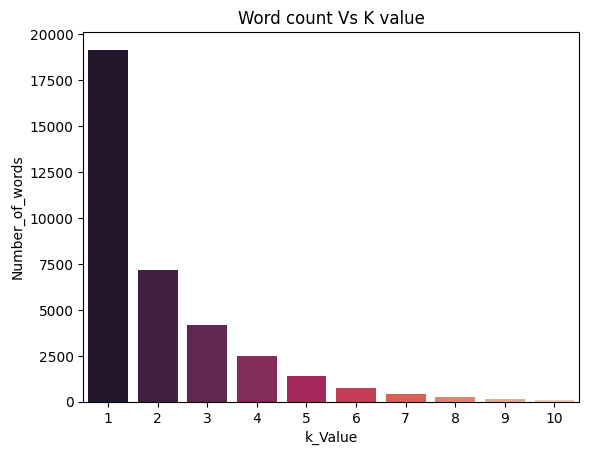

In [73]:
fig = sns.barplot(df[0:10],
            x="k_Value",
            y="Number_of_words",
            #hue = "k_Value",
            palette = 'rocket')
fig.set_title('Word count Vs K value')
plt.savefig('Stats', bbox_inches='tight')
